# Data initalization

In [289]:
import pandas as pd
from pathlib import Path
import os

TRAIN_PATH = Path(os.path.abspath("")).parent / 'dataset' / 'dreaddit-train.csv'
TEST_PATH = Path(os.path.abspath("")).parent / 'dataset' / 'dreaddit-test.csv'

train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# Data visualization

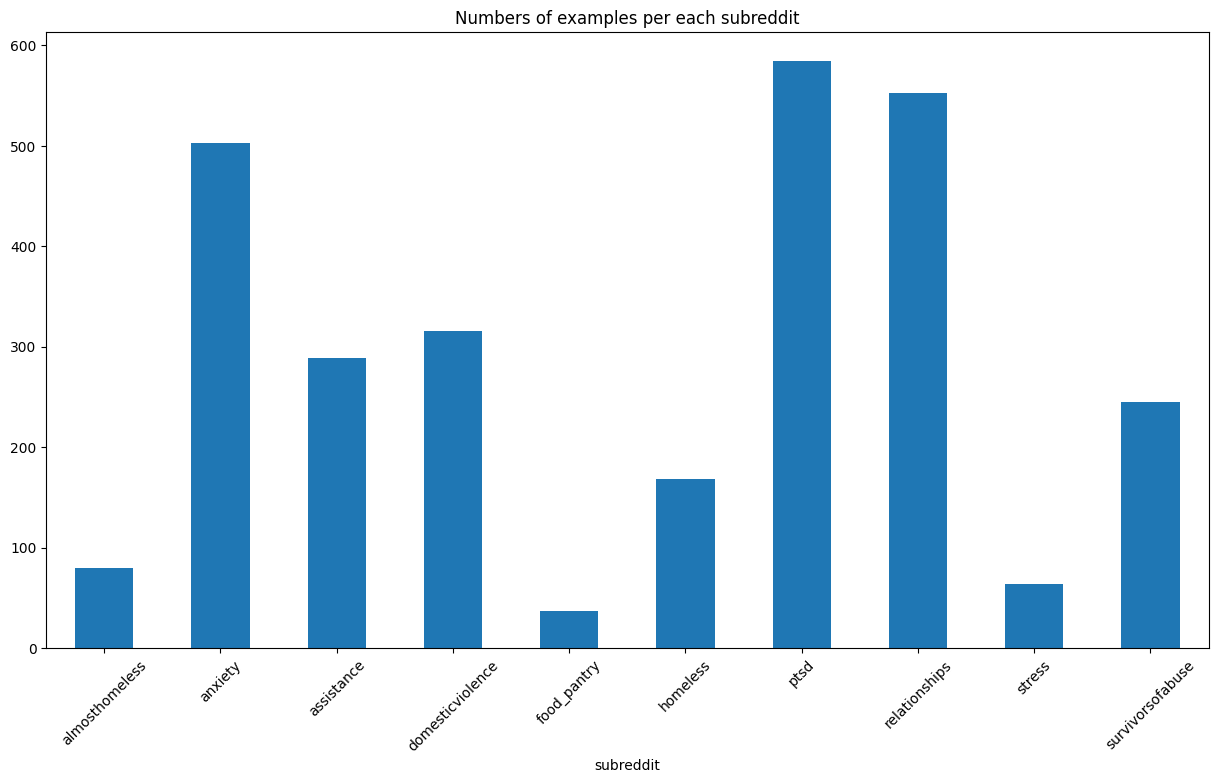

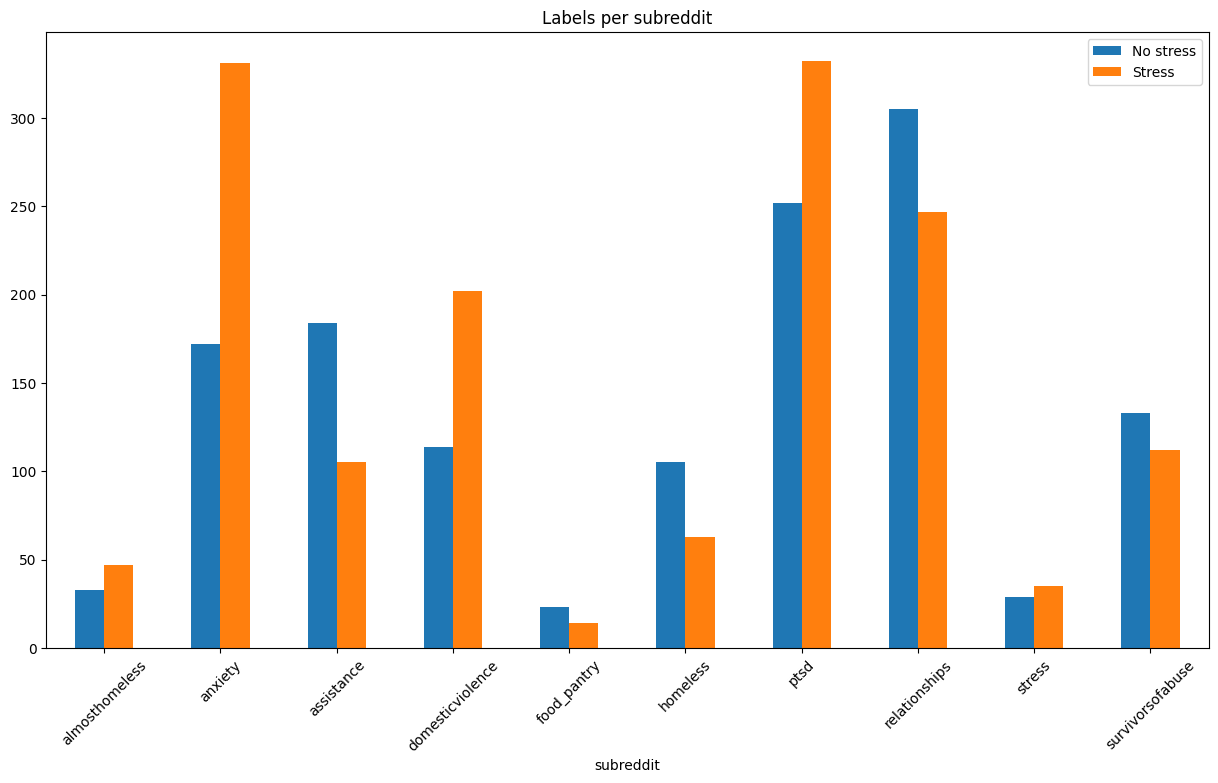

In [129]:
from matplotlib import pyplot as plt

def data_vis(train_df):
    # plt.clf()
    df=train_df.groupby(['subreddit']).size()
    # df=df.unstack()
    df.plot(kind='bar', figsize=(15,8))
    plt.xticks(rotation=45)
    plt.title("Numbers of examples per each subreddit")
    plt.show()

    # plt.clf()
    df=train_df.groupby(['subreddit',"label"]).size()
    df=df.unstack()
    df.plot(kind='bar', figsize=(15,8))
    plt.legend(["No stress", "Stress"])
    plt.xticks(rotation=45)
    plt.title("Labels per subreddit")
    plt.show()


data_vis(train)

# Spacy initalization

In [130]:
import spacy

nlp = spacy.load('en_core_web_sm')

## Preprocessing tasks
This includes:
- Tokenization
- Stop word removal
- Digit removal
- Punctuation removal

In [290]:
def tokenize(text):
    doc = nlp(text)
    tokens = []

    for tok in doc:
        if not tok.is_stop and not tok.is_digit and not tok.is_punct:
            tokens.append(tok.lemma_)

    return tokens

train['processed_text'] = train['text'].apply(tokenize)
test['processed_text'] = test['text'].apply(tokenize)

In [249]:
print(train['text'][0])
print(train.shape[0])

He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f'n worried about my heart. I do happen to have a physical in 48 hours.
2838


## Word2Vec vectorizer

### Initialization of the model

In [133]:
from gensim.models import Word2Vec

TRAIN_MODEL_PATH = "train-word2vec.model"

if os.path.isfile(TRAIN_MODEL_PATH):
    model_train = Word2Vec.load(TRAIN_MODEL_PATH)
else:
    model_train = Word2Vec(train['processed_text'],
                vector_size=300,
                window=5,
                min_count=2,
                workers=16)

In [134]:
model_train.save(TRAIN_MODEL_PATH)

In [135]:
print(train.shape)

(2838, 117)


### Averaging of the word vectors and removing out of vocabulary words

In [136]:
import numpy as np

def document_vector(doc):
    doc = [word for word in doc if word in model_train.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(300)
    return np.mean(model_train.wv[doc], axis=0)

train["doc_vector"] = train["processed_text"].apply(document_vector)
test["doc_vector"] = test["processed_text"].apply(document_vector)

print(train["doc_vector"].values[0])

[ 1.82966087e-02  2.28721306e-01  1.38271181e-02  1.71465948e-01
 -5.68039808e-03 -3.24850082e-01  1.23808332e-01  5.79141498e-01
  3.33172157e-02 -1.47081852e-01 -9.31452308e-03 -2.01108202e-01
  2.31003929e-02 -8.86944879e-04 -2.13394761e-01 -1.39149383e-01
  1.26618817e-01  1.61098950e-02  9.87317488e-02 -5.30184098e-02
 -1.15971111e-01  2.75589544e-02  1.84545144e-01  2.76999474e-02
  2.45881781e-01  1.03134662e-01 -3.12557429e-01  7.90973976e-02
 -9.59975496e-02 -2.04448804e-01 -2.21756902e-02 -1.07393876e-01
  4.51302379e-02 -2.40703654e-02 -3.93792801e-02  1.00864150e-01
  7.51932114e-02 -2.36395240e-01  2.89463960e-02 -5.38930073e-02
 -1.46910593e-01  3.39115486e-02 -6.08472992e-03 -1.50112584e-01
  4.92394567e-02  2.52619714e-01  6.69374466e-02  1.28548145e-01
 -4.93556373e-02  2.07036570e-01  5.32669686e-02  1.21945748e-03
 -1.61326990e-01 -5.68142813e-03 -6.74650744e-02  2.86115170e-01
  6.64488524e-02  4.24060673e-02 -2.24683546e-02 -6.71296054e-03
 -3.10583729e-02 -1.61427

In [137]:
print(train.shape)

(2838, 118)


# Logistic regression model

In [138]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=130, solver="liblinear")

x = list(train["doc_vector"])
y = train["label"]

clf.fit(x, y)
y_pred = clf.predict(list(test["doc_vector"]))

acc_score = accuracy_score(test["label"], y_pred)
rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)

print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")

Accuracy: 0.6461538461538462
Recall: 0.8021680216802168
Precision: 0.6218487394957983
F1: 0.7005917159763315


### TF-IDF weighted averaging of word embeddings

In [139]:
from sklearn.feature_extraction.text import TfidfVectorizer

Concat all sentences from train and test set

In [140]:
lemmatized_sentences_train = train["processed_text"].apply(lambda x: " ".join(x))

Initalize TfidfVectorizer

In [141]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(lemmatized_sentences_train)
feature_names = tfidf.get_feature_names()
feature_name_weight = dict(zip(feature_names, tfidf.idf_))

### Add Tfidf weight to word2vec embeddings

In [142]:
def weighted_average(doc):
    doc = [word for word in doc if word in model_train.wv.key_to_index and word in feature_name_weight]
    tfidf_weights = np.array([feature_name_weight[word] for word in doc ]).reshape(-1, 1)

    if len(doc) == 0:
        return np.zeros(300)
    return np.mean(model_train.wv[doc] * tfidf_weights, axis=0)

train["doc_vector_tfidf"] = train["processed_text"].apply(weighted_average)
test["doc_vector_tfidf"] = test["processed_text"].apply(weighted_average)

In [143]:
log_reg = LogisticRegression(C=70, solver="liblinear")

x = list(train["doc_vector_tfidf"])
y = train["label"]
log_reg.fit(x, y)

y_pred = log_reg.predict(list(test["doc_vector_tfidf"]))

acc_score = accuracy_score(test["label"], y_pred)
rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)

print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")

Accuracy: 0.7132867132867133
Recall: 0.8102981029810298
Precision: 0.6889400921658986
F1: 0.7447073474470735


## BERT classification model

Initalize tokenizer

In [278]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/sscekic/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /home/sscekic/.cache/huggingface/transformers/0e1bbfda7f63a

Split training set into train and validation

In [250]:
train["processed_sentence"] = train["processed_text"].apply(lambda x: " ".join(x))

In [251]:
from sklearn.model_selection import train_test_split

train_bert, validation_bert = train_test_split(train, test_size=0.3)

In [252]:
train_bert = train_bert[["processed_sentence", "label"]]
validation_bert = validation_bert[["processed_sentence", "label"]]

Convert Pandas dataframe to Dataset

In [253]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_bert)
validation_ds = Dataset.from_pandas(validation_bert)

In [259]:
train_ds = train_ds.rename_column("processed_sentence", "text")
validation_ds = validation_ds.rename_column("processed_sentence", "text")

Convert text to tokens

In [260]:
def preprocess_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_train_ds = train_ds.map(preprocess_function, batched=True)
tokenized_validation_ds = validation_ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/1986 [00:00<?, ? examples/s]

Map:   0%|          | 0/852 [00:00<?, ? examples/s]

In [261]:
print(tokenized_train_ds)

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 1986
})


Dinamically padding sentences to the longest length in a batch

In [262]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [263]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

id2label = {0: "NOT STRESSFUL", 1: "STRESSFUL"}
label2id = {"NOT STRESSFUL": 0, "STRESSFUL": 1}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /home/sscekic/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NOT STRESSFUL",
    "1": "STRESSFUL"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NOT STRESSFUL": 0,
    "STRESSFUL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file htt

Select 2 columns from pandas dataframes

In [265]:
import evaluate

accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [268]:
training_args = TrainingArguments(
    output_dir="BERT_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_validation_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/home/sscekic/anaconda3/envs/tarlab1/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1986
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 250
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.fo

Epoch,Training Loss,Validation Loss


***** Running Evaluation *****
  Num examples = 852
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
Saving model checkpoint to BERT_model/checkpoint-125
Configuration saved in BERT_model/checkpoint-125/config.json
Model weights saved in BERT_model/checkpoint-125/pytorch_model.bin
tokenizer config file saved in BERT_model/checkpoint-125/tokenizer_config.json
Special tokens file saved in BERT_model/checkpoint-125/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 852
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, text. If __index_level_0__, text are not e

TrainOutput(global_step=250, training_loss=0.5179965209960937, metrics={'train_runtime': 225.6987, 'train_samples_per_second': 17.599, 'train_steps_per_second': 1.108, 'total_flos': 72330304370832.0, 'train_loss': 0.5179965209960937, 'epoch': 2.0})

In [284]:
tokenizer = AutoTokenizer.from_pretrained("BERT_model/checkpoint-250")

Didn't find file BERT_model/checkpoint-250/added_tokens.json. We won't load it.
loading file BERT_model/checkpoint-250/vocab.txt
loading file BERT_model/checkpoint-250/tokenizer.json
loading file None
loading file BERT_model/checkpoint-250/special_tokens_map.json
loading file BERT_model/checkpoint-250/tokenizer_config.json


In [292]:
test["processed_sentence"] = test["processed_text"].apply(lambda x: " ".join(x))
test_bert = test[["processed_sentence", "label"]]
test_ds = Dataset.from_pandas(test_bert)
test_ds = test_ds.rename_column("processed_sentence", "text")

Dataset({
    features: ['text', 'label'],
    num_rows: 715
})


In [300]:
inputs = tokenizer(test_ds["text"], truncation=True, padding=True, return_tensors="pt")

In [306]:
import torch

model = AutoModelForSequenceClassification.from_pretrained("BERT_model/checkpoint-250")
with torch.no_grad():
    logits = model(**inputs).logits
    print(logits)
    predicted_class_id = logits.argmax(dim=1)

    print(predicted_class_id)

loading configuration file BERT_model/checkpoint-250/config.json
Model config DistilBertConfig {
  "_name_or_path": "BERT_model/checkpoint-250",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "NOT STRESSFUL",
    "1": "STRESSFUL"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NOT STRESSFUL": 0,
    "STRESSFUL": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "vocab_size": 30522
}

loading weights file BERT_model/checkpoint-250/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassificati

tensor([[-0.2448,  0.0106],
        [ 0.8071, -1.0040],
        [-1.2060,  1.1778],
        ...,
        [-1.0402,  1.0076],
        [ 1.1228, -1.2677],
        [-0.1065,  0.0207]])
tensor([1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
        0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
        0, 1, 0, 0

In [315]:
y_pred = predicted_class_id.tolist()

acc_score = accuracy_score(test["label"], y_pred)
rec_score = recall_score(test["label"], y_pred)
prec_score = precision_score(test["label"], y_pred)
f1 = f1_score(test["label"], y_pred)

print(f"Accuracy: {acc_score}")
print(f"Recall: {rec_score}")
print(f"Precision: {prec_score}")
print(f"F1: {f1}")

[1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 